# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=0)
RANDOM_STATE = 1

# Generate data

In [2]:
def generate_data(num_alphas, samples_per_alpha, rvs_size):
    '''
    params:
        num_alphas: number of alphas generated between MIN_ALPHA and MAX_ALPHA inclusive
        samples_per_alpha: number of samples (rows) for each alpha 
        rvs_size: number of RV samples (columns) per row
    '''

    MIN_ALPHA = 2.01
    MAX_ALPHA = 3.00

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * samples_per_alpha, 1 + rvs_size), float)

    row = 0
    for alpha in np.linspace(MIN_ALPHA, MAX_ALPHA, num=num_alphas):
        
        #lilo: alpha = round(alpha, 2)
        
        # generate samples (rows) for current alpha
        for i in range(samples_per_alpha):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=rvs_size, random_state=RANDOM_STATE)
            row += 1

    # suffle rows
    np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    # convert rows of X to a histogram H
    nbins = np.max(X)
    H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

    # log scale H rows
    logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)
    return logH, y

# Create Model

In [3]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    
    # ============
    # input-layer
    # ============
    model.add(Dense(units=layers[0]
                      , input_dim=n_features
                      , kernel_initializer=init
                      , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                      , activity_regularizer=l2(a_reg_lr) if a_reg else None
                      , use_bias= (not batch_normalization)
                    ))
    
    
    if batch_normalization:
        model.add(BatchNormalization())
    
    model.add(Activation(activation))

    if dropout > 0:
        model.add(Dropout(dropout))

    # ==============
    # hidden-layers
    # ==============
    for units in layers[1:]:
        model.add(Dense(units=units
                        , kernel_initializer=init
                        , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                        , activity_regularizer=l2(a_reg_lr) if a_reg else None
                        , use_bias= (not batch_normalization)
                        ))

    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation(activation))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    # =============
    # output-layer
    # =============
    model.add(Dense(units=1
                    , kernel_initializer=init
                    , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                    , activity_regularizer=l2(a_reg_lr) if a_reg else None
                    , use_bias= (not batch_normalization)
                    ))
    
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation('linear'))
    
    # if dropout > 0:
    #     model.add(Dropout(dropout))

    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

    return model

# Training

In [4]:
BATCH_SIZE = 32
MODEL_PREFIX = 'yulesimon'

def train(X_train, y_train, X_val, y_val):
    model = create_model(X_train.shape[1], 
                         layers=[256, 256], 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=True, 
                         dropout=0.0, 
                         optimizer=Adam(lr=1e-2), 
                         #optimizer=SGD(lr=1e-3, momentum=0.9, decay=0.01), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=0)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/{}_{}'.format(MODEL_PREFIX, date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=3000, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=0)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    model = keras.models.load_model(model_path)
    return model, history.history

In [5]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.figure(figsize=(5,5))
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

# Trials

In [6]:
def trail(num_alphas, samples_per_alpha, rvs_size):
    sqrt_mse, model, history = _trail(num_alphas, samples_per_alpha, rvs_size)
    return sqrt_mse

def _trail(num_alphas, samples_per_alpha, rvs_size):
    print('trail( num_alphas={}, samples_per_alpha={}, rvs_size={} )'.format(num_alphas, samples_per_alpha, rvs_size))
    
    X, y = generate_data(num_alphas=num_alphas, samples_per_alpha=samples_per_alpha, rvs_size=rvs_size)

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # split train/val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

    # training
    model, history = train(X_train, y_train, X_val, y_val)

    # predict
    y_pred = model.predict(X_test).flatten()

    # evaluate
    squared_error = np.square(y_test - y_pred)
    mse = (squared_error).mean(axis=0)
    return np.sqrt(mse), model, history

trail( num_alphas=100, samples_per_alpha=100, rvs_size=1000 )
sqrt(mse): 0.010401112748193435


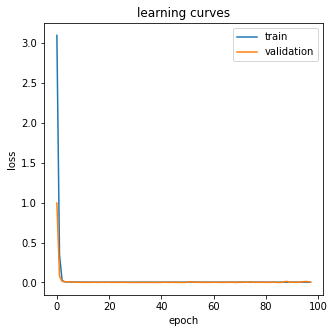

In [7]:
if True:
    sqrt_mse, m, h = _trail(num_alphas=100, samples_per_alpha=100, rvs_size=1000)
    print('sqrt(mse):', sqrt_mse)
    plot_learning_curves(h)

trail( num_alphas=100, samples_per_alpha=1000, rvs_size=1000 )
sqrt(mse): 0.017349139086295727


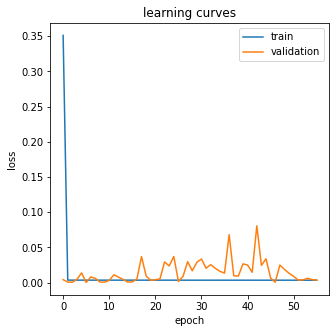

In [8]:
if True:
    sqrt_mse, m, h = _trail(num_alphas=100, samples_per_alpha=1000, rvs_size=1000)
    print('sqrt(mse):', sqrt_mse)
    plot_learning_curves(h)

In [9]:
if False:
    sqrt_mse, m, h = _trail(num_alphas=256, samples_per_alpha=100, rvs_size=1000)
    print('sqrt(mse):', sqrt_mse)
    plot_learning_curves(h)

trail( num_alphas=256, samples_per_alpha=100, rvs_size=100 )
sqrt(mse): 0.024860668075314618


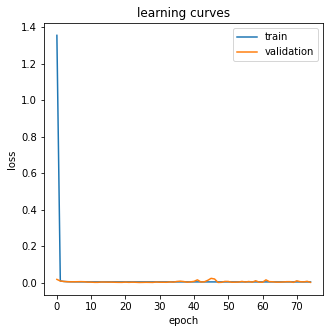

In [12]:
if True:
    sqrt_mse, m, h = _trail(num_alphas=256, samples_per_alpha=100, rvs_size=100)
    print('sqrt(mse):', sqrt_mse)
    plot_learning_curves(h)

In [11]:
if False:
    sqrt_mse, m, h = _trail(num_alphas=100, samples_per_alpha=1000, rvs_size=1000)
    print('sqrt(mse):', sqrt_mse)
    plot_learning_curves(h)